In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

%matplotlib inline
plt.style.use('seaborn-whitegrid')

## Process a sample file from air traffic datasets

## What's the number of recored aircrafts from the largest 10 airlines in Dec, 2021?

### Goal:
- Final processed dataframe meets the protocol for using influx-client API for importing to InfluxDB.
- Basic time series visualization can be conducted based on this processed result

### Steps:
1. Examine data
2. Select features
3. Check missing values
4. Filter out by feature - callsign
5. Count the number of aircrafts for selected airline in each day
6. Formatting the result for importing and visualization

#### Examine data

In [41]:
flight_nov_21 = pd.read_csv('flightlist_20211201_20211231.csv')

In [21]:
flight_nov_21.head(5)

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,LAN9712,NaN,e8027a,CC-BBF,B788,KLAX,KMIA,2021-11-30 00:04:09+00:00,2021-12-01 03:25:21+00:00,2021-12-01 00:00:00+00:00,33.946884,-118.434299,0.0,25.784683,-80.347392,129.54
1,RDA5003,NaN,510146,NaN,NaN,ZBTJ,NaN,2021-11-30 01:13:09+00:00,2021-12-01 02:07:36+00:00,2021-12-01 00:00:00+00:00,39.187683,117.438832,609.6,33.607504,14.337444,5745.48
2,KMF903,NaN,700024,NaN,NaN,OMAA,OM11,2021-11-30 01:38:15+00:00,2021-12-01 13:43:43+00:00,2021-12-01 00:00:00+00:00,24.378204,54.780426,914.4,24.385971,54.875206,1257.30
3,LGT2878,NaN,4244a1,NaN,NaN,EBLG,EBLG,2021-11-30 02:08:50+00:00,2021-12-01 22:25:38+00:00,2021-12-01 00:00:00+00:00,50.629257,5.431366,304.8,50.656906,5.475094,396.24
4,CCA589,NaN,7816b5,NaN,NaN,KLAX,EGLL,2021-11-30 02:11:40+00:00,2021-12-01 07:46:59+00:00,2021-12-01 00:00:00+00:00,33.947800,-118.424602,0.0,51.464951,-0.437523,152.40


In [19]:
flight_nov_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561535 entries, 0 to 2561534
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   callsign      object 
 1   number        object 
 2   icao24        object 
 3   registration  object 
 4   typecode      object 
 5   origin        object 
 6   destination   object 
 7   firstseen     object 
 8   lastseen      object 
 9   day           object 
 10  latitude_1    float64
 11  longitude_1   float64
 12  altitude_1    float64
 13  latitude_2    float64
 14  longitude_2   float64
 15  altitude_2    float64
dtypes: float64(6), object(10)
memory usage: 312.7+ MB


#### Select features

In [62]:
to_keep = ['callsign', 'day']
nov_21 = flight_nov_21[to_keep].copy()

#### Check missing values

In [64]:
nov_21

,callsign,day
0,LAN9712,2021-12-01 00:00:00+00:00
1,RDA5003,2021-12-01 00:00:00+00:00
2,KMF903,2021-12-01 00:00:00+00:00
3,LGT2878,2021-12-01 00:00:00+00:00
4,CCA589,2021-12-01 00:00:00+00:00
...,...,...
2561530,N3547H,2021-12-31 00:00:00+00:00
2561531,N31SR,2021-12-31 00:00:00+00:00
2561532,VT756,2021-12-31 00:00:00+00:00
2561533,VOI809,2021-12-31 00:00:00+00:00


In [63]:
nov_21.isnull().mean() * 100

callsign    0.0
day         0.0
dtype: float64

#### Filter out by feature - callsign

In [66]:
nov_21['airline'] = nov_21['callsign'].map(lambda x: x[:3])
nov_21

,callsign,day,airline
0,LAN9712,2021-12-01 00:00:00+00:00,LAN
1,RDA5003,2021-12-01 00:00:00+00:00,RDA
2,KMF903,2021-12-01 00:00:00+00:00,KMF
3,LGT2878,2021-12-01 00:00:00+00:00,LGT
4,CCA589,2021-12-01 00:00:00+00:00,CCA
...,...,...,...
2561530,N3547H,2021-12-31 00:00:00+00:00,N35
2561531,N31SR,2021-12-31 00:00:00+00:00,N31
2561532,VT756,2021-12-31 00:00:00+00:00,VT7
2561533,VOI809,2021-12-31 00:00:00+00:00,VOI


In [68]:
# flights from American airline company in Novermber, 2021
nov_21[nov_21.airline == 'AAL']

,callsign,day,airline
138,AAL9817,2021-12-01 00:00:00+00:00,AAL
183,AAL51,2021-12-01 00:00:00+00:00,AAL
211,AAL128,2021-12-01 00:00:00+00:00,AAL
245,AAL823,2021-12-01 00:00:00+00:00,AAL
263,AAL9726,2021-12-01 00:00:00+00:00,AAL
...,...,...,...
2561401,AAL1134,2021-12-31 00:00:00+00:00,AAL
2561437,AAL1466,2021-12-31 00:00:00+00:00,AAL
2561488,AAL1788,2021-12-31 00:00:00+00:00,AAL
2561499,AAL1128,2021-12-31 00:00:00+00:00,AAL


In [71]:
# a list of 10 largest airline compamies in the world
top_airlines = ['AAL', 'DAL', 'UAL', 'SWA', 'RYR', 'UAE', 'CSN', 'CES', 'CCA', 'DLH']

In [72]:
nov_21 = nov_21[nov_21.airline.isin(top_airlines)]

In [73]:
nov_21

,callsign,day,airline
4,CCA589,2021-12-01 00:00:00+00:00,CCA
7,CES7551,2021-12-01 00:00:00+00:00,CES
9,UAE9329,2021-12-01 00:00:00+00:00,UAE
14,CSN461,2021-12-01 00:00:00+00:00,CSN
18,CES709S,2021-12-01 00:00:00+00:00,CES
...,...,...,...
2561445,DAL428,2021-12-31 00:00:00+00:00,DAL
2561488,AAL1788,2021-12-31 00:00:00+00:00,AAL
2561499,AAL1128,2021-12-31 00:00:00+00:00,AAL
2561509,UAE607,2021-12-31 00:00:00+00:00,UAE


#### Count the number of aircrafts for selected airline in each day

In [134]:
nov_21_top = nov_21.groupby(['day', 'airline']).size().reset_index(name='total')
nov_21_top

,day,airline,total
0,2021-12-01 00:00:00+00:00,AAL,2726
1,2021-12-01 00:00:00+00:00,CCA,183
2,2021-12-01 00:00:00+00:00,CES,187
3,2021-12-01 00:00:00+00:00,CSN,215
4,2021-12-01 00:00:00+00:00,DAL,2567
...,...,...,...
304,2021-12-31 00:00:00+00:00,DLH,603
305,2021-12-31 00:00:00+00:00,RYR,1986
306,2021-12-31 00:00:00+00:00,SWA,3333
307,2021-12-31 00:00:00+00:00,UAE,308


#### Formatting the result for importing and visualization

In [135]:
nov_21_top = nov_21_top.pivot(index='day', columns='airline', values='total')
nov_21_top.fillna(0, inplace=True)
nov_21_top.iloc[:,1:] = nov_21_top.iloc[:,1:].astype(int)

In [143]:
nov_21_top.head(5)

,AAL,CCA,CES,CSN,DAL,DLH,RYR,SWA,UAE,UAL
day,,,,,,,,,,
2021-12-01 00:00:00+00:00,2726.0,183.0,187.0,215.0,2567.0,847.0,1793.0,3091.0,208.0,1890.0
2021-12-02 00:00:00+00:00,2955.0,175.0,197.0,232.0,2643.0,881.0,1754.0,2878.0,203.0,1938.0
2021-12-03 00:00:00+00:00,2986.0,180.0,221.0,201.0,2727.0,944.0,2358.0,2909.0,215.0,1938.0
2021-12-04 00:00:00+00:00,2964.0,144.0,180.0,200.0,2521.0,891.0,2122.0,2931.0,227.0,1868.0
2021-12-05 00:00:00+00:00,2647.0,173.0,195.0,225.0,2337.0,891.0,2292.0,2824.0,225.0,1839.0


In [137]:
nov_21_top.rename_axis(None, axis=1, inplace=True)

In [139]:
nov_21_top.index = pd.to_datetime(nov_21_top.index)

In [147]:
nov_21_top.index = nov_21_top.index.map(lambda t: t.strftime("%Y-%m-%d"))

In [148]:
nov_21_top

,AAL,CCA,CES,CSN,DAL,DLH,RYR,SWA,UAE,UAL
day,,,,,,,,,,
2021-12-01,2726.0,183.0,187.0,215.0,2567.0,847.0,1793.0,3091.0,208.0,1890.0
2021-12-02,2955.0,175.0,197.0,232.0,2643.0,881.0,1754.0,2878.0,203.0,1938.0
2021-12-03,2986.0,180.0,221.0,201.0,2727.0,944.0,2358.0,2909.0,215.0,1938.0
2021-12-04,2964.0,144.0,180.0,200.0,2521.0,891.0,2122.0,2931.0,227.0,1868.0
2021-12-05,2647.0,173.0,195.0,225.0,2337.0,891.0,2292.0,2824.0,225.0,1839.0
2021-12-06,2962.0,159.0,196.0,200.0,2643.0,893.0,2279.0,3130.0,209.0,1943.0
2021-12-07,2676.0,153.0,202.0,197.0,2582.0,781.0,1757.0,2868.0,225.0,1951.0
2021-12-08,2600.0,178.0,205.0,197.0,2421.0,839.0,1790.0,2961.0,221.0,1897.0
2021-12-09,2954.0,161.0,219.0,202.0,2561.0,858.0,1741.0,2878.0,224.0,1908.0


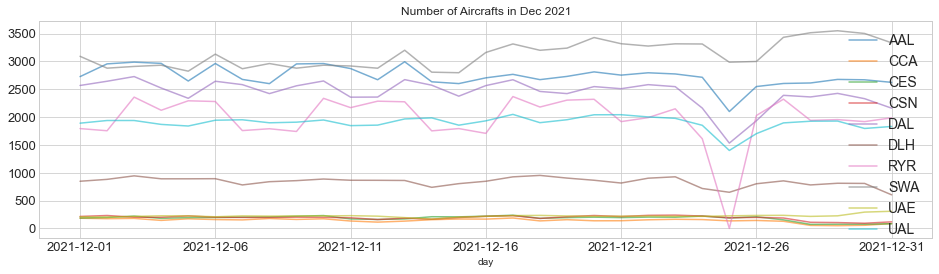

In [157]:
# plot time variable
nov_21_top.plot(figsize=(16, 4), title='Number of Aircrafts in Dec 2021', fontsize=13, alpha=0.6)
plt.legend(fontsize=14);